# Visualize Results: Impute Performance - "Corrupted" Experiment

This notebook should answer the questions: *Which imputer works best to re-construct missing values?*

## Notebook Structure 

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import plot_metric_vs_missing_fraction, plot_rank_vs_fraction_by_type, draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT = "corrupted"

EXPERIMENT_PATH = Path(f"../data/experiments/cluster5/{EXPERIMENT}/")

IMPUTE_RESULT_TYPE = "impute_performance_mean"
FIGURES_PATH = Path(f"../paper/figures/{EXPERIMENT}/{IMPUTE_RESULT_TYPE}")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

CONFIDENCE_INTERVAL = 90

In [4]:
Path(FIGURES_PATH/IMPUTE_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

## Import the data

In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 27s, sys: 3.07 s, total: 1min 30s
Wall time: 1min 38s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.430927,1.316501,NaN,NaN,NaN
1,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,12.367895,31.128048,NaN,NaN,NaN
2,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.716819,1.870398,NaN,NaN,NaN
3,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.048134,0.108173,NaN,NaN,NaN
4,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,1.479995,3.087714,NaN,NaN,NaN


In [6]:
impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
assert len(results["strategy"].unique()) == 1
impute_results.drop(["experiment", "train", "strategy", "baseline", "corrupted", "imputed"], axis=1, inplace=True) 
impute_results = impute_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "test": "Imputation"
    },
    axis = 1
)
impute_results.head()

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation
16850,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,8.268300
16853,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_mean,RMSE,8.894009
16856,AutoKerasImputer,40922,MCAR,0.50,gyro_y,impute_performance_mean,RMSE,8.953483
16859,AutoKerasImputer,40922,MCAR,0.10,gyro_y,impute_performance_mean,RMSE,9.034770
16862,AutoKerasImputer,32,MAR,0.01,input4,impute_performance_mean,RMSE,6.540805


## Compute Imputer Ranking

In [7]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

clf_row_idx = impute_results["metric"] == CLF_METRIC
reg_row_idx = impute_results["metric"] == REG_METRIC

In [8]:
impute_results.loc[clf_row_idx, "Imputation Rank"] = impute_results[clf_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False, na_option="bottom", method="min")["Imputation"]
impute_results.loc[reg_row_idx, "Imputation Rank"] = impute_results[reg_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=True, na_option="bottom", method="min")["Imputation"]
impute_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Imputation Rank
16850,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,8.268300,1.0
16853,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_mean,RMSE,8.894009,2.0
16856,AutoKerasImputer,40922,MCAR,0.50,gyro_y,impute_performance_mean,RMSE,8.953483,2.0
16859,AutoKerasImputer,40922,MCAR,0.10,gyro_y,impute_performance_mean,RMSE,9.034770,2.0
16862,AutoKerasImputer,32,MAR,0.01,input4,impute_performance_mean,RMSE,6.540805,3.0
...,...,...,...,...,...,...,...,...,...
33683,GAINImputer,1220,MCAR,0.10,keyword_id,impute_performance_mean,RMSE,103807.911287,6.0
33686,GAINImputer,1220,MNAR,0.01,keyword_id,impute_performance_mean,RMSE,52415.470853,7.0
33689,GAINImputer,1220,MNAR,0.30,keyword_id,impute_performance_mean,RMSE,65698.732367,7.0
33692,GAINImputer,1220,MNAR,0.50,keyword_id,impute_performance_mean,RMSE,72615.728406,7.0


### Check if results are complete

In [9]:
# should have equal length
impute_results["Imputer"].value_counts(dropna=False)

VAEImputer_0        828
VAEImputer_noise    828
ModeImputer         828
KNNImputer          828
ForestImputer       825
GAINImputer         824
AutoKerasImputer    655
Name: Imputer, dtype: int64

### Robustness: check which imputers yielded `NaN` values

In [10]:
for col in impute_results.columns:
    na_sum = impute_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = impute_results[col].isna()
        print(impute_results.loc[na_idx, "Imputer"].value_counts(dropna=False))
        print("\n")

### Check if the scores/ranks are normally distributed

Otherwise it might not make sense to show the standard deviations / confidence intervals it the plots below.

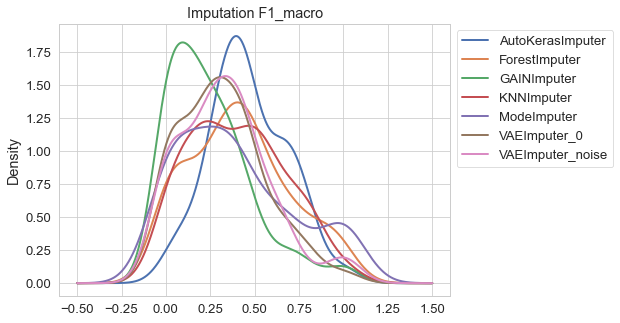

In [11]:
kde_data = impute_results.loc[clf_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

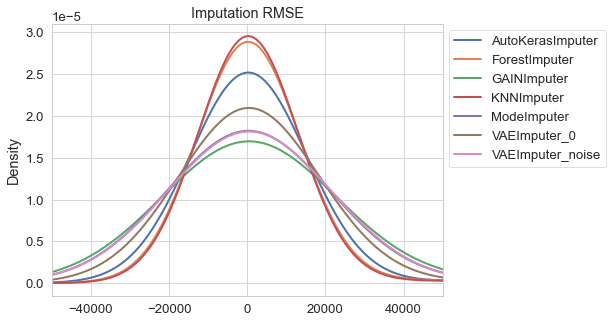

In [12]:
kde_data = impute_results.loc[reg_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {REG_METRIC}", figsize=(7,5), xlim=(-50000, 50000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

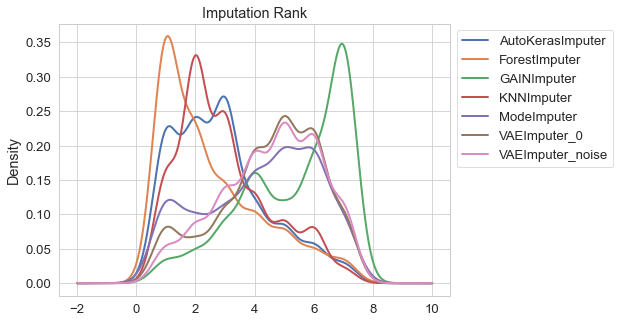

In [13]:
kde_data = impute_results[["Imputer", "Imputation Rank"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation Rank")

kde_data.plot(kind="kde", title="Imputation Rank", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

## Application Scenario 1 - Imputation Performance

In [14]:
impute_results.groupby(["metric"]).size()

metric
F1_macro     729
RMSE        4887
dtype: int64

The data is not equally distributed between categorical and numerical imputation tasks, so simply averaging the ranks, as done in the plots below, could be misleading.

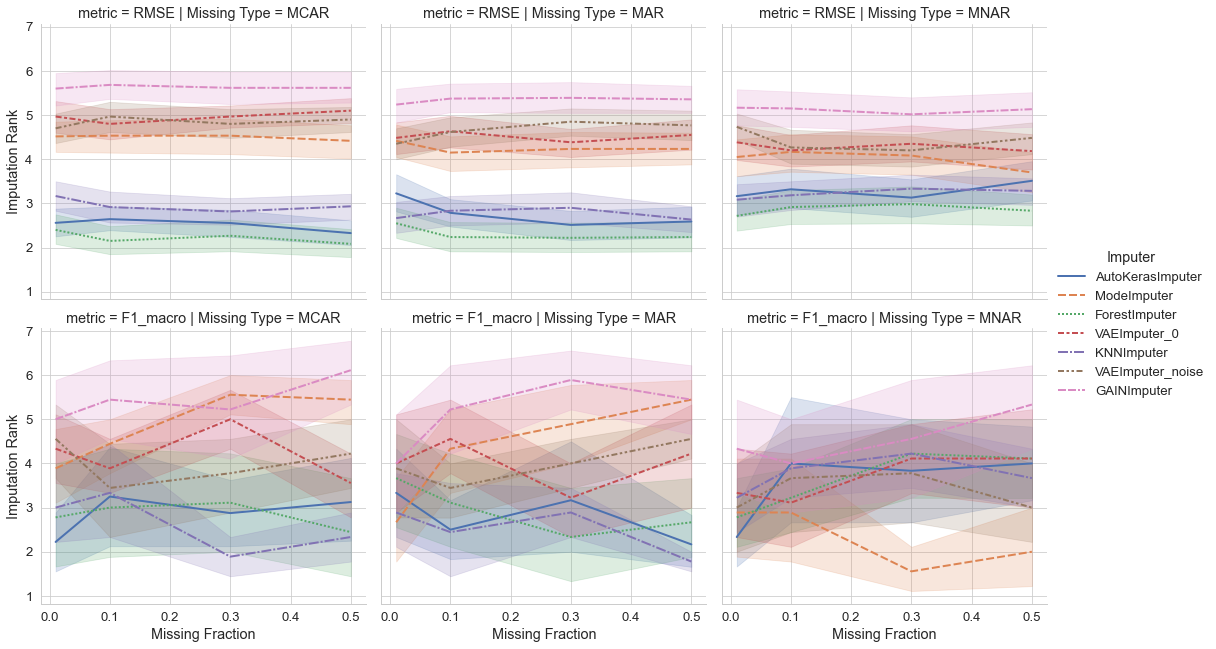

In [15]:
plot_rank_vs_fraction_by_type(
    impute_results,
    CONFIDENCE_INTERVAL,
    FIGURES_PATH,
    f"rank_lineplot.svg"
)

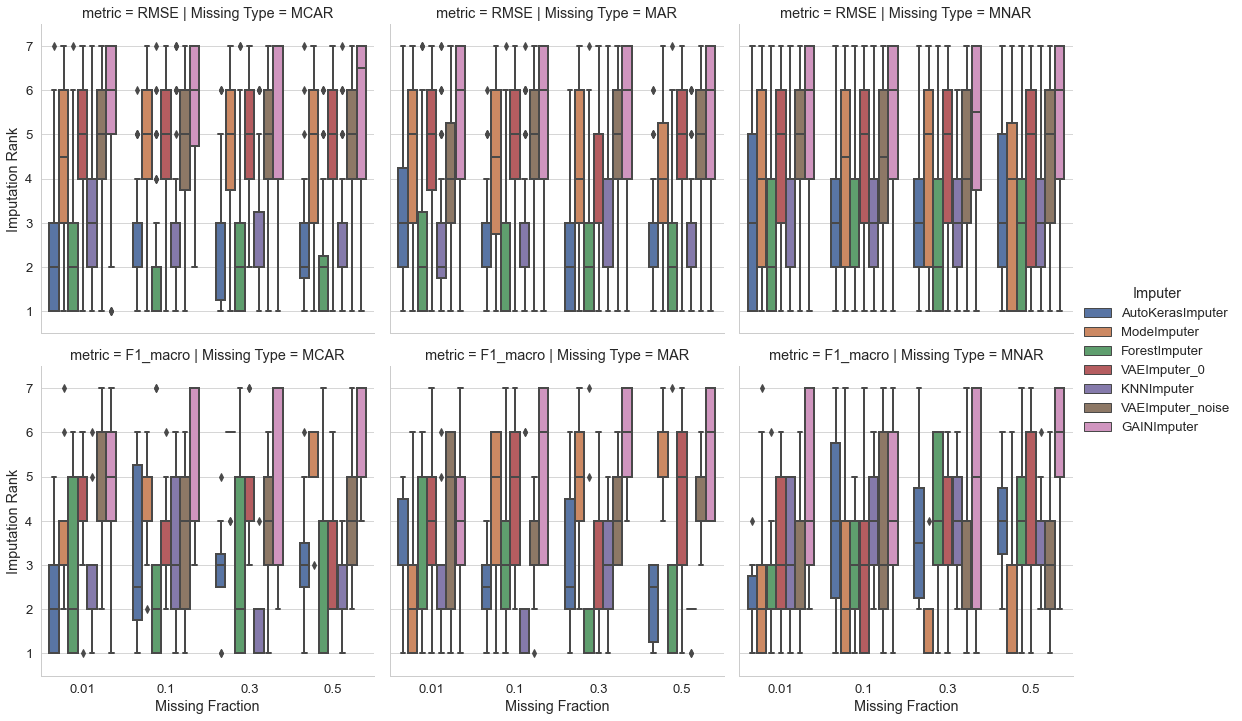

In [16]:
draw_cat_box_plot(
    impute_results,
    "Imputation Rank",
    (0.5, 7.5),
    FIGURES_PATH,
    "rank_boxplot.svg"
)

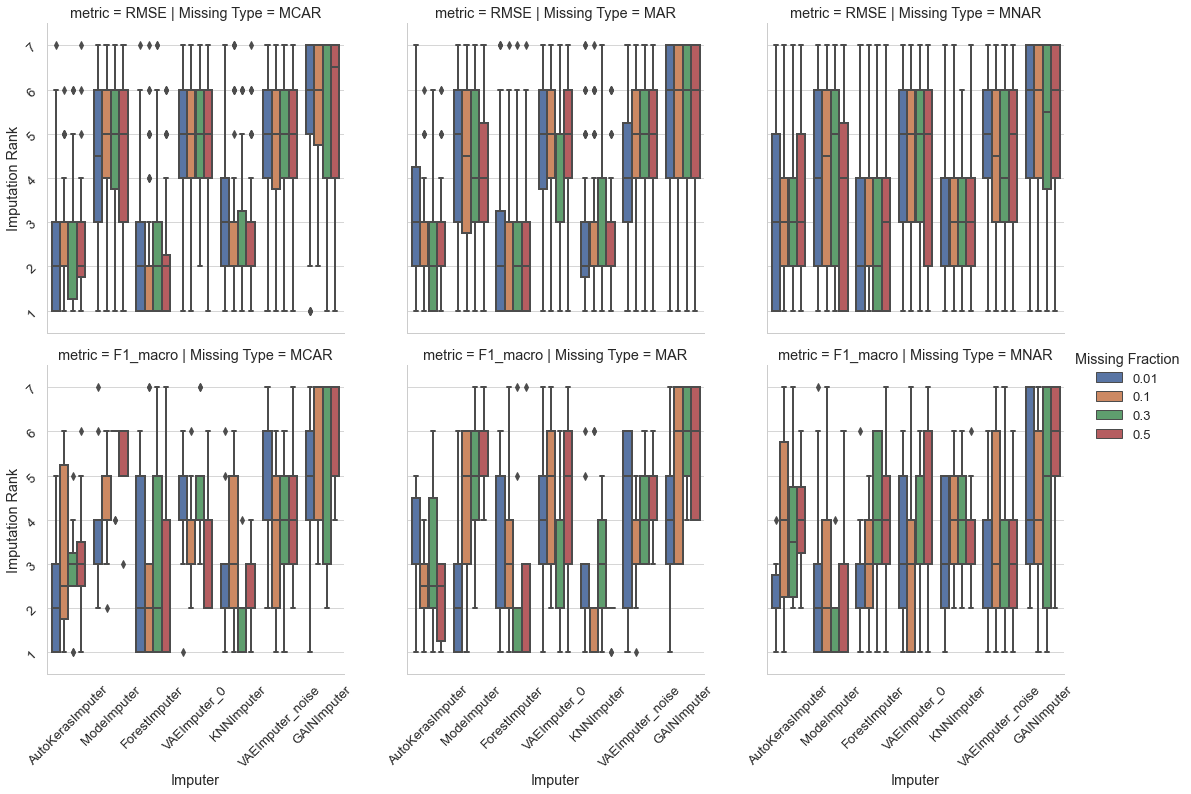

In [17]:
ax = sns.catplot(
        x="Imputer", 
        y="Imputation Rank",
        hue="Missing Fraction", 
        col="Missing Type",
        row="metric",
        data=impute_results, 
        kind="box",
        height=5, 
        col_order=["MCAR", "MAR", "MNAR"]
    )
ax.set(ylim=(0.5, 7.5))
for axi in ax.axes.flatten():
    axi.tick_params(rotation = 45)